In [44]:
import IMProToo
import xarray as xr
from matplotlib import cm, colors
import matplotlib.pyplot as plt
import proplot as pplt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import sys
import  os       
import tikzplotlib
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

from matplotlib.patches import Rectangle 

directorio_actual = os.getcwd()
print("Estoy en:", directorio_actual)   # ubicacion de donde estamos

Estoy en: C:\Users\Kanty\Documents\GitHub\RadarVisualisation\PlotRadar


In [52]:
#cargamos la base
ds = xr.open_dataset('C:/Users/Kanty/Documents/mrr2c/2024_0806_mrr2c_1.nc')
ds.head()   # para ver la cantidad de variables y tipos

<xarray.Dataset>
Dimensions:                        (time: 5, level: 5, band: 5)
Coordinates:
  * band                           (band) float64 0.0 1.0 2.0 3.0 4.0
  * level                          (level) float64 0.0 1.0 2.0 3.0 4.0
  * time                           (time) datetime64[ns] 2024-08-06T00:00:21 ...
Data variables: (12/22)
    attenuated_radar_reflectivity  (time, level) float64 ...
    averaging_time                 (time) float64 ...
    calibration_constant           (time) float64 ...
    device_serial_number           (time) object ...
    drop_size                      (time, level, band) float64 ...
    fall_velocity                  (time, level) float64 ...
    ...                             ...
    service_version                (time) object ...
    spectral_drop_density          (time, level, band) float64 ...
    spectral_reflectivity          (time, level, band) float64 ...
    time_zone                      (time) object ...
    transfer_function              (time, level) float64 ...
    valid_spectra_percentage       (time) float64 ...
Attributes:
    software:  mrr2c (https://github.com/peterkuma/mrr2c)
    version:   3.0.0
    created:   2024-08-06T15:50:11Z

In [53]:
# Uso de colores hexadecimal personificados 
paleta0 = ['#ccd8ff','#3366ff','#9fdf9f','#00b300','#ffff00','#ffcc30','#e62e00','#ff6600','#fff0e5','#c03fc0','#602060']
paleta1 = ['#ffe5d9','#ffb3b3','#ffcc99','#ffffcc','#ccffcc','#b3e0ff','#b3b3ff','#e5ccff','#ffcce5','#ffd9b3','#ffe5b3']
paleta2 = ['#390099','#6C0079','#9E0059','#CF0057','#FF0054','#FF2A2A','#FF5400','#FF8900','#FFBD00','#FFC317','#FFC82C']
paleta3 = ['#000814','#001329','#001D3D','#002952','#003566','#40594D','#807C33','#A08E27','#C0A01A','#FFC300','#FFD60A']

def add_no_data(ax,times,xlim):
    cs = ax.contourf([times[0],times[-1]], [0,600], np.ones((2,2)), 
                    colors='none', edgecolor='red', hatches=['////'], zorder=0)
    for i, collection in enumerate(cs.collections):
        collection.set_edgecolor('gray3')
    middleIndex = int((len(times) - 1)/2)
    ax.text(xlim[0], 300, 'Sin Datos', 
                color='gray8',
                ha='left',va='center',
                zorder=1,
                )

def plot_mrr2(xlim, times, heights, Ze, Vf=None, hora_local=False, ax=None,
              ytickloc='both', colorhex = paleta0):                   # aca cargar paleta de colores personalizada a usar
    cmap4 = []
    stops = [0,1./10,2./10,3./10,4./10,5./10,6./10,7./10,8./10,9./10,1]
    for value, color in zip(stops,colorhex):
            cmap4.append((value,color))
    dbzmap = colors.LinearSegmentedColormap.from_list("custom",cmap4)
    dbzmap.set_bad('0.9',1)
    bounds = np.arange(-5,50,1)
    norm = colors.BoundaryNorm(bounds, dbzmap.N)

    if hora_local:
      xlabel = r'Hora Local $\rightarrow$'
    else:
      xlabel = r'Hora UTC $\rightarrow$'

    if heights[-1]< 5000:
      ylim = [0, 3600]
    else:
      ylim = [0, 8000]

    total_seconds = (xlim[1]-xlim[0]).total_seconds()
    
    if total_seconds <= 14400:
      xlocator=('hour',range(0,24,1))
      xminorlocator=('minute',30)
    elif (total_seconds>14400) and (total_seconds<=82800.0):
      xlocator=('hour',range(0,24,3))
      xminorlocator=('hour',range(0,24,1))
    else:      
      xlocator=('hour',range(0,24,6))
      xminorlocator=('hour',range(0,24,2))


    if Vf is None:

      if ax is None:
        fig, ax = pplt.subplots(refwidth=5, refaspect=3)

      mZe = ax.pcolormesh(times, heights, Ze,  
                        norm=norm, cmap=dbzmap, 
                        shading='auto', # permite que tickmark esté en centro de celda
                      #   extend='both'
                        )		

      ax.format(	ultitle='Reflectividad Equivalente',
                      xrotation=False,
                      xformatter='concise',
                      xlocator=xlocator,
                      xminorlocator=xminorlocator,
                      ylim=ylim,
                      yticklabelloc=ytickloc,
                      ytickloc='both',
                      xticklabelsize=8,
                      suptitle='Radar Perfilador MRR en UOH Rancagua',
                      ylabel='Altitud [msnm]',
                      xlabel=xlabel,
                  )
      ax.colorbar(mZe, loc='r', label='[dBZ]', length=0.7,)
        
      if xlim != '':
          ax.format(xlim=xlim)    
      
    else:
      
      fig, ax = pplt.subplots(nrows=2, refwidth=5, refaspect=3)

      mZe = ax[0].pcolormesh(times, heights, Ze,  
                        norm=norm, cmap=dbzmap, 
                        shading='auto', # permite que tickmark esté en centro de celda
                       #extend='both'
                        )		
      add_no_data(ax[0], times, xlim)   
      
      mVf = ax[1].pcolormesh(times, heights, Vf, 
                            vmin=-3,vmax=10,        # Aca cambiar a la paleta de colores predeterminadas a usar 
                             #cmap='Spectral',      # Colores paleta espectro visual
                             #cmap='RdYlGn',        # Colores paleta rojo-amarillo-verde
                             #cmap='RdYlBu',        # Colores paleta rojo-amarillo-azul
                             #cmap='RdGy',          # Colores paleta rojo-gris
                             cmap='RdBu',          # Colores paleta rojo-azul
                             #cmap='PuOr',           # Colores paleta purpura-naranja
                             #cmap='PRGn',          # Colores paleta purpura(rojiza)-verde(amarillento)
                             #cmap='PiYG',          # Colores paleta rosa-amarillo-verde
                             #cmap='BrBG',          # Colores paleta marron-azul(verdoso)
                            shading='auto',
                           #extend='both'
                            )	
      add_no_data(ax[1], times, xlim)

      ax[0].format(	ultitle='Reflectividad Equivalente',
                      xrotation=False,
                      xformatter='concise',
                      xlocator=xlocator,
                      xminorlocator=xminorlocator,
                      ylim=ylim,
                      yticklabelloc='both',
                      ytickloc='both',
                      xticklabelsize=8,
                      suptitle='Radar Perfilador MRR en UOH Rancagua',
                      ylabel='Altitud [msnm]',
                      xlabel=xlabel,
                  )
      ax[0].colorbar(mZe, loc='r', label='[dBZ]', length=0.4,)
      
      ax[1].format(	ultitle='Velocidad de caída',
                      xrotation=False,
                      #   xformatter='%b-%d\n%H:%M',
                      xformatter='concise',
                      xlocator=xlocator,
                      xminorlocator=xminorlocator,
                      ylim=ylim,
                      yticklabelloc='both',
                      ytickloc='both',
                      xticklabelsize=8,
          )
      ax[1].colorbar(mVf, loc='r', label='[m/s]', length=0.4, 
                    extend='both')
  
      if xlim != '':
          ax[0].format(xlim=xlim)
          ax[1].format(xlim=xlim)
    
    fig.show()	

C:\Users\Kanty\anaconda3\envs\myenv\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\Kanty\anaconda3\envs\myenv\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\Kanty\AppData\Local\Temp\ipykernel_12432\1887986037.py:142: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


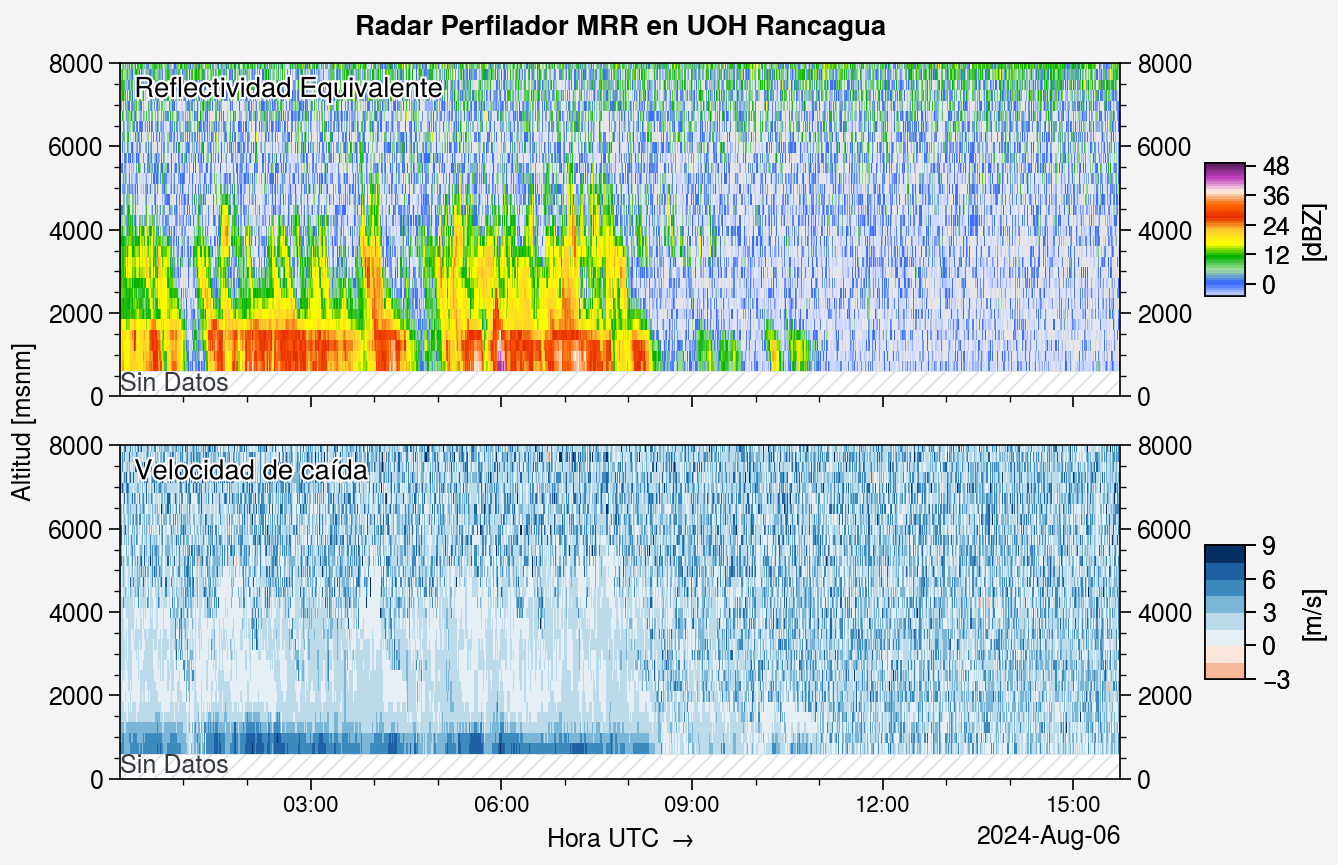

In [54]:
new_time = pd.to_datetime(ds.time.values)
xlim = [new_time[0], new_time[-1]]
heights = ds.height[0,:]+500
Ze = ds['attenuated_radar_reflectivity'].T
Vf = ds['fall_velocity'].T
# llamar a la funcion para plotear
plot_mrr2(xlim,pd.to_datetime(ds.time.values) , heights, Ze, Vf, hora_local=False)
plt.savefig("2024_0806_mrr2c_1.png")

## Suavizado de datos Vertical

In [57]:
def suavizar_datos(datos, suavizado):

    if suavizado % 2 == 0:              # Imprime error en caso impar
        raise ValueError("El valor de suavizado debe ser un número impar.")

                                  
    marco = (suavizado - 1) // 2        # Calcula marcos superior e inferior

                                        # Crear una matriz extendida para manejar los bordes (rellenada con ceros, tipo convolucion)
    extended_data = np.zeros((datos.shape[0] + suavizado -1, datos.shape[1]))
    extended_data[marco:marco + datos.shape[0], :] = datos

                                        # Matriz para almacenar los datos nuevos
    datos_suavizados = np.zeros(datos.shape)

                                       # Aplicar el suavizado mediante un promedio
    for i in range(datos.shape[0]):
        datos_suavizados[i, :] = np.mean(extended_data[i:i + suavizado, :], axis=0)

    return datos_suavizados

In [58]:
matrizPrueba = np.array([[1, 2, 3],
                         [4, 5, 6],
                         [7, 8, 9]])

suavizado = 5  
marco = (suavizado - 1) // 2
matrizSalida = np.zeros((matrizPrueba.shape[0] + suavizado - 1, matrizPrueba.shape[1]))
matrizSalida[marco:marco + matrizPrueba.shape[0], :] = matrizPrueba

print(matrizSalida)

[[0. 0. 0.]
 [0. 0. 0.]
 [1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]
 [0. 0. 0.]
 [0. 0. 0.]]


C:\Users\Kanty\anaconda3\envs\myenv\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\Kanty\anaconda3\envs\myenv\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\Kanty\AppData\Local\Temp\ipykernel_17764\1887986037.py:142: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


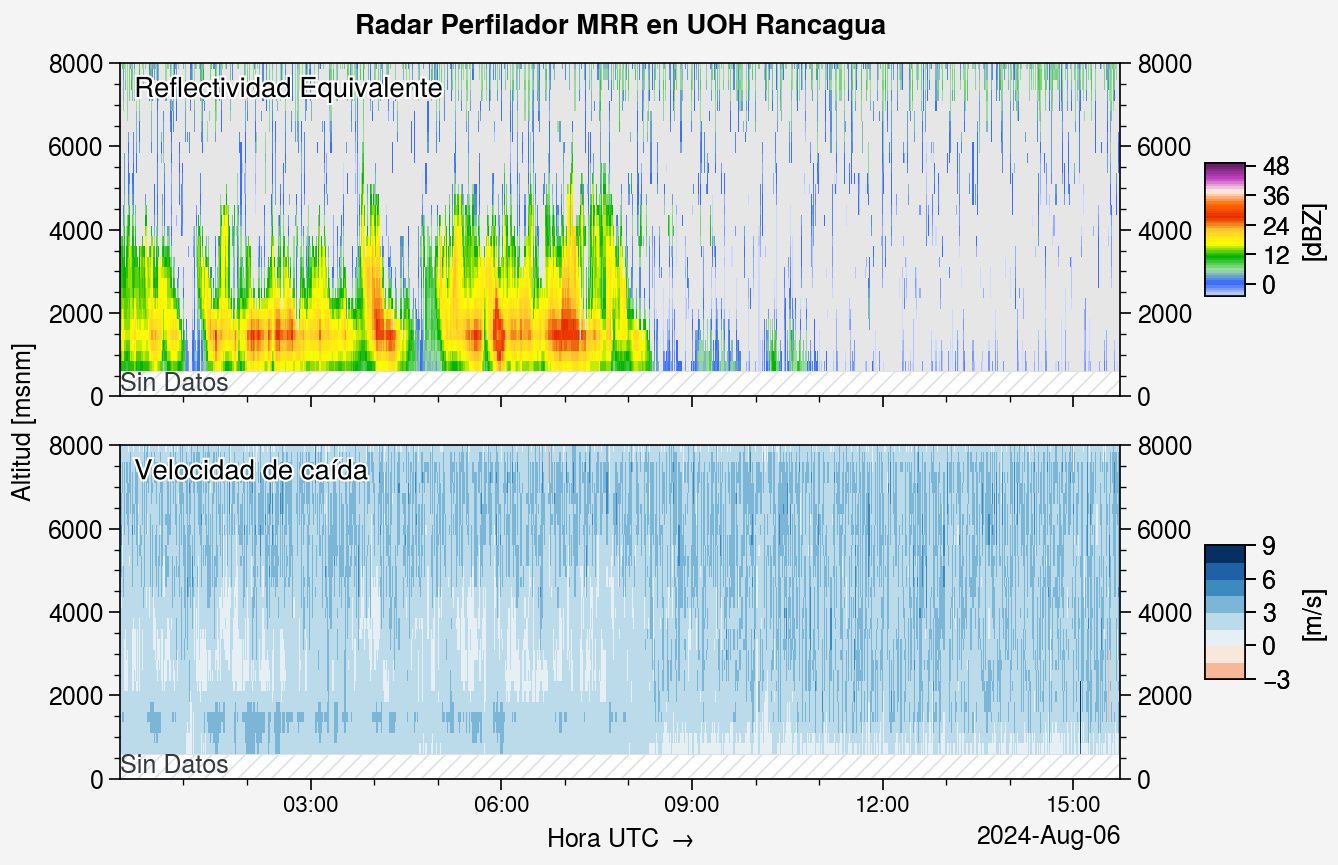

In [59]:
heights = ds.height[0, :] + 500
Ze = ds['attenuated_radar_reflectivity'].T
Vf = ds['fall_velocity'].T

suavizado = 7  # Definir el tamaño del suavizado
Ze_suavizado = suavizar_datos(Ze, suavizado)
Vf_suavizado = suavizar_datos(Vf, suavizado)

plot_mrr2(xlim, pd.to_datetime(ds.time.values), heights, Ze_suavizado, Vf_suavizado, hora_local=False)


## Suavizado de Datos Horizontal

In [60]:
def suavizar_datos_horizontal(datos, suavizado):
    if suavizado % 2 == 0:  # Imprime error en caso de ser un número impar
        raise ValueError("El valor de suavizado debe ser un número impar.")

    marco = (suavizado - 1) // 2  # Calcula marcos izquierdo y derecho

    # Crear una matriz extendida para manejar los bordes (rellenada con ceros, tipo convolucion)
    extended_data = np.zeros((datos.shape[0], datos.shape[1] + suavizado - 1))
    extended_data[:, marco:marco + datos.shape[1]] = datos

    # Matriz para almacenar los datos suavizados
    datos_suavizados = np.zeros(datos.shape)

    # Aplicar el suavizado horizontalmente (por cada nivel de tiempo)
    for i in range(datos.shape[1]):  # Recorre cada columna (altura)
        datos_suavizados[:, i] = np.mean(extended_data[:, i:i + suavizado], axis=1)

    return datos_suavizados


C:\Users\Kanty\anaconda3\envs\myenv\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\Kanty\anaconda3\envs\myenv\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\Kanty\AppData\Local\Temp\ipykernel_17764\1887986037.py:142: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


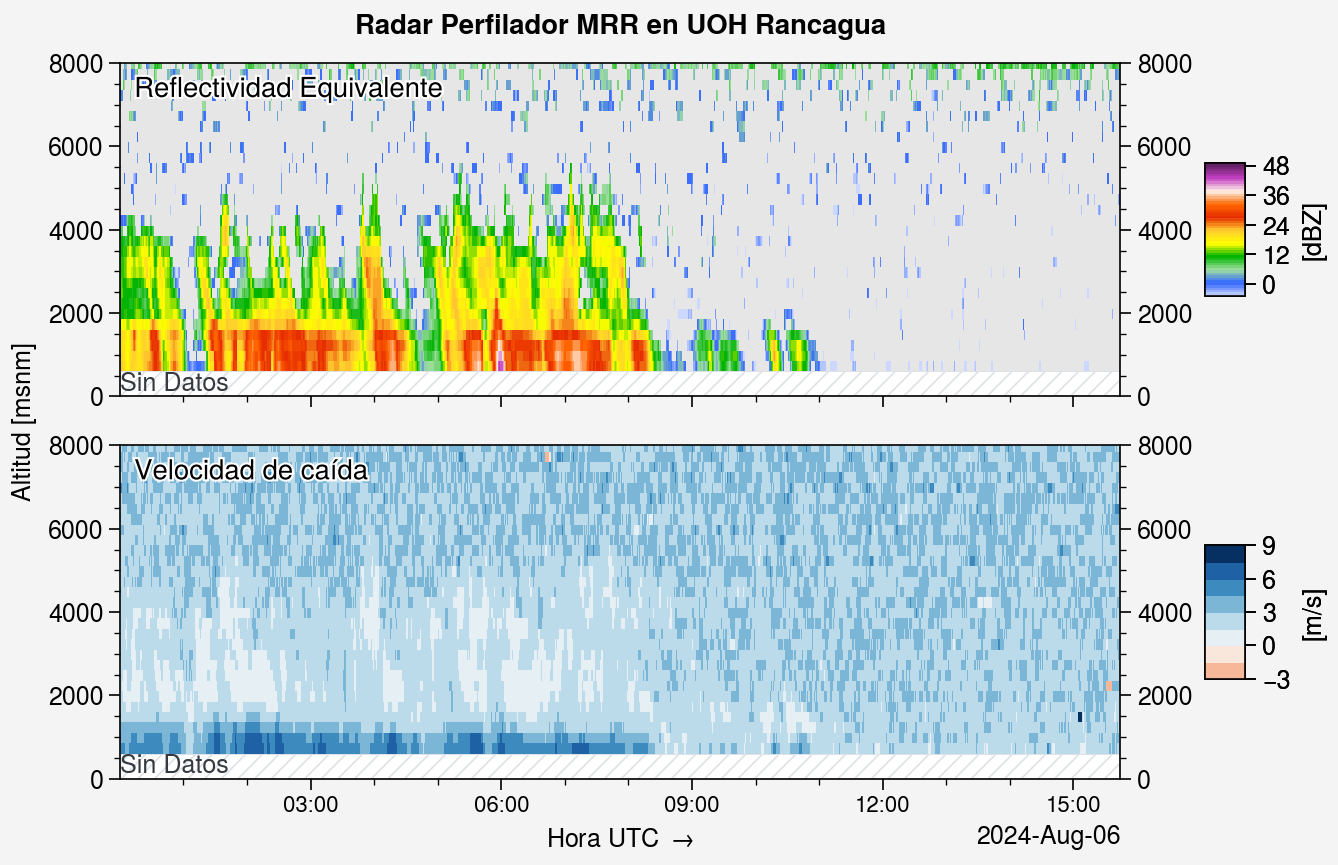

In [61]:
suavizado = 7  
Ze_suavizado_horizontal = suavizar_datos_horizontal(Ze, suavizado)
Vf_suavizado_horizontal = suavizar_datos_horizontal(Vf, suavizado)

# Ploteamos los datos suavizados
plot_mrr2(xlim, pd.to_datetime(ds.time.values), heights, Ze_suavizado_horizontal, Vf_suavizado_horizontal, hora_local=False)


## Prueba sobre gradiente

In [55]:
def calcular_gradiente(datos, suavizado):

    if suavizado % 2 == 0:
        raise ValueError("El valor de suavizado debe ser un número impar.")
        
    marco = (suavizado - 1) // 2

    extended_data = np.zeros((datos.shape[0] + 2 * marco, datos.shape[1]))
    extended_data[marco:marco + datos.shape[0], :] = datos

    gradiente_datos = np.zeros(datos.shape)

    for i in range(datos.shape[0]):
        gradiente_datos[i, :] = (extended_data[i + suavizado - 1, :] - extended_data[i, :]) / (2 * marco)

    return gradiente_datos


C:\Users\Kanty\AppData\Local\Temp\ipykernel_17764\1887986037.py:142: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


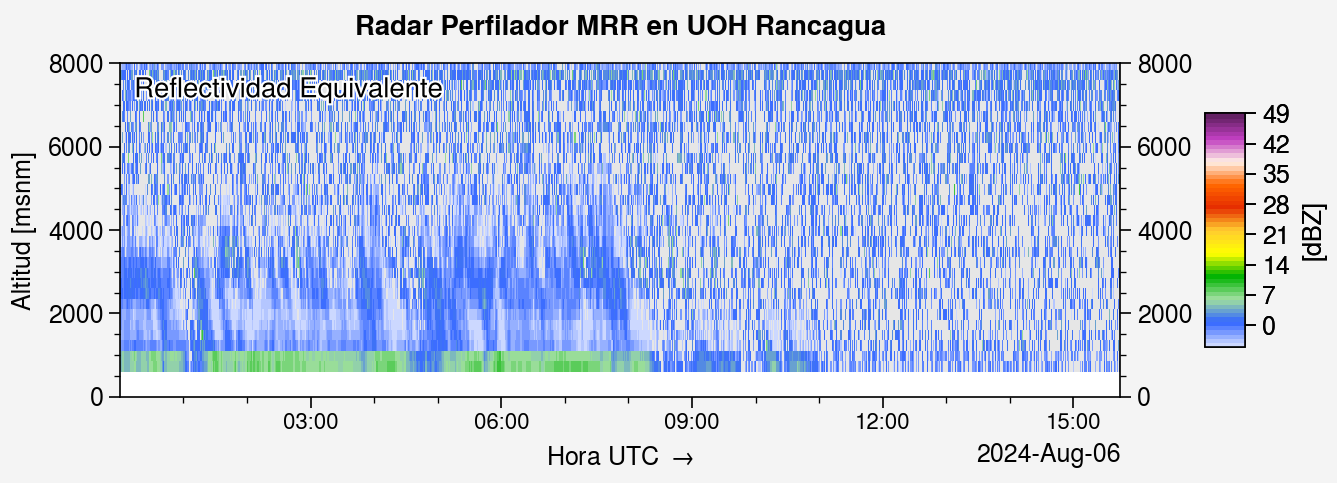

In [63]:
heights = ds.height[0, :] + 500
Ze = ds['attenuated_radar_reflectivity'].T

# Aplicar el cálculo del gradiente a los datos de reflectividad
suavizado = 5  # Puedes ajustar el tamaño del suavizado
gradiente_Ze = calcular_gradiente(Ze, suavizado)

# Graficar el gradiente de reflectividad
plot_mrr2(xlim, pd.to_datetime(ds.time.values), heights, gradiente_Ze, hora_local=False)
plt.savefig("gradiente_mrr2.png")


## Prueba sobre isoterma cero

In [6]:
def encontrar_maximos_reflectividad(Ze, heights, limite=25):

    alturas_max = []
    tiempos_max = []
    
    # Convertir Ze a numpy para evitar problemas de indexado
    Ze_np = Ze.values if isinstance(Ze, xr.DataArray) else Ze

    # Recorrer cada columna (cada instante de tiempo)
    for tiempo in range(Ze_np.shape[1]):
        for altura in range(heights.size-1, -1, -1):  # Recorrer desde la mayor altura hacia abajo
            if Ze_np[altura, tiempo] > limite:
                alturas_max.append(heights[altura])
                tiempos_max.append(tiempo)
                break  # Se detiene al encontrar el primer valor mayor al límite
    
    return tiempos_max, alturas_max


def plot_isoterma(xlim, times, heights, Ze, Vf=None, hora_local=False, ax=None, colorhex=paleta0):
    # Inicializar listas para almacenar alturas promedio y los tiempos correspondientes
    alturas_promedio = []
    tiempos_validos = []
    
    # Iterar sobre cada columna (cada instante de tiempo)
    for t in range(Ze.shape[1]):
        # Filtrar las alturas que tienen reflectividad por encima de 25 dBZ en este tiempo
        alturas_validas = heights[Ze[:, t] > 25]
        
        # Si se encuentran alturas válidas, calcular el promedio
        if len(alturas_validas) > 0:
            promedio_altura = np.mean(alturas_validas)
            alturas_promedio.append(promedio_altura)
            tiempos_validos.append(t)
    
    # Crear el gráfico de reflectividad si no existe un eje
    if ax is None:
        fig, ax = pplt.subplots(refwidth=5, refaspect=3)

    # Graficar reflectividad sin alterar colores originales
    mZe = ax.pcolormesh(times, heights, Ze, shading='auto')

    # Colocar la línea segmentada en los puntos de altura promedio
    ax.plot(pd.to_datetime(times)[tiempos_validos], alturas_promedio, linestyle='--', color='r', lw=2, label='Isoterma Cero Promedio', zorder=10)

    # Formatear el gráfico
    ax.format(ultitle='Reflectividad(Promedio)',
              ylabel='Altura [msnm]',
              xlabel='Tiempo',
              suptitle='Isoterma Cero Segmentada sobre Reflectividad',
              xrotation=45)

    # Agregar leyenda
    ax.legend()

    # Guardar el gráfico
    plt.show()


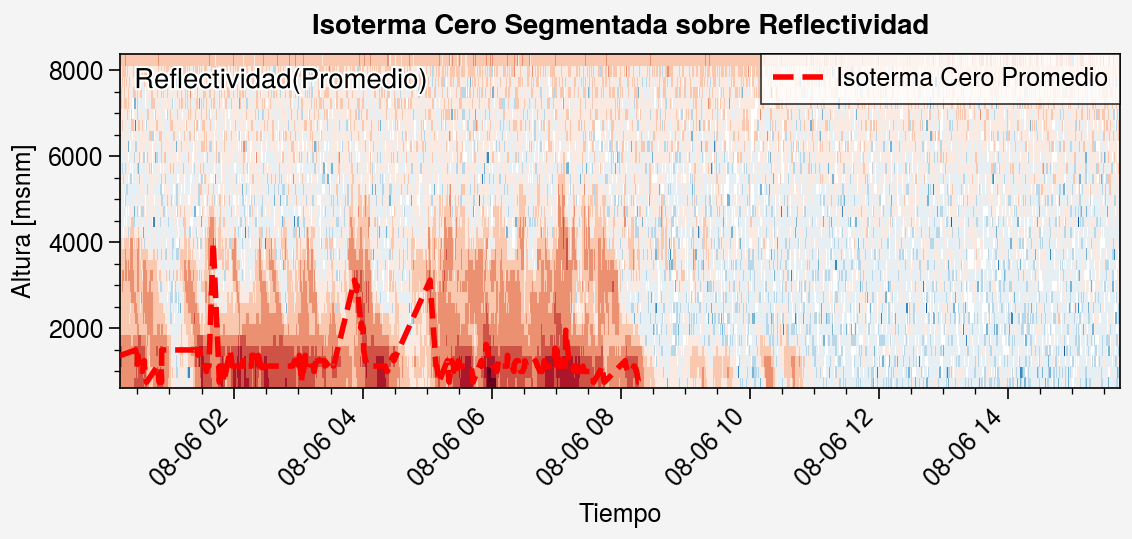

In [65]:
# Para los datos originales
plot_isoterma(xlim, pd.to_datetime(ds.time.values), heights, Ze, Vf, hora_local=False)


In [66]:
def encontrar_maximos_reflectividad(Ze, heights, limite=25):

    alturas_max = []
    tiempos_max = []
    
    # Convertir Ze a numpy para evitar problemas de indexado
    Ze_np = Ze.values if isinstance(Ze, xr.DataArray) else Ze

    # Recorrer cada columna (cada instante de tiempo)
    for tiempo in range(Ze_np.shape[1]):
        for altura in range(heights.size-1, -1, -1):  # Recorrer desde la mayor altura hacia abajo
            if Ze_np[altura, tiempo] > limite:
                alturas_max.append(heights[altura])
                tiempos_max.append(tiempo)
                break  # Se detiene al encontrar el primer valor mayor al límite
    
    return tiempos_max, alturas_max

## Filtro adaptativo


In [67]:
def filtro_adaptativo_entorno(datos, ventana_pequeña, ventana_grande, umbral_desviacion):
    datos_filtrados = np.copy(datos)
    
    for i in range(datos.shape[0]):
        inicio = max(0, i - ventana_grande // 2)
        fin = min(len(datos), i + ventana_grande // 2 + 1)
        
        
        datos_locales = datos[inicio:fin]
        desviacion_estandar = np.std(datos_locales)
        
        # Decidir si se trata de ruido o datos estables
        if desviacion_estandar > umbral_desviacion and np.mean(datos_locales) < umbral_desviacion:
            # Datos ruidosos -> Aplicar suavizado más agresivo (ventana grande)
            suavizado = np.mean(datos[inicio:fin], axis=0)
        else:
            # Datos estables -> Suavizado menos agresivo (ventana pequeña)
            inicio_pequena = max(0, i - ventana_pequeña // 2)
            fin_pequena = min(len(datos), i + ventana_pequeña // 2 + 1)
            suavizado = np.mean(datos[inicio_pequena:fin_pequena], axis=0)
        
        # Asignar el valor suavizado a los datos filtrados
        datos_filtrados[i, :] = suavizado
    
    return datos_filtrados


C:\Users\Kanty\anaconda3\envs\myenv\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\Kanty\anaconda3\envs\myenv\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\Kanty\AppData\Local\Temp\ipykernel_17764\1887986037.py:142: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


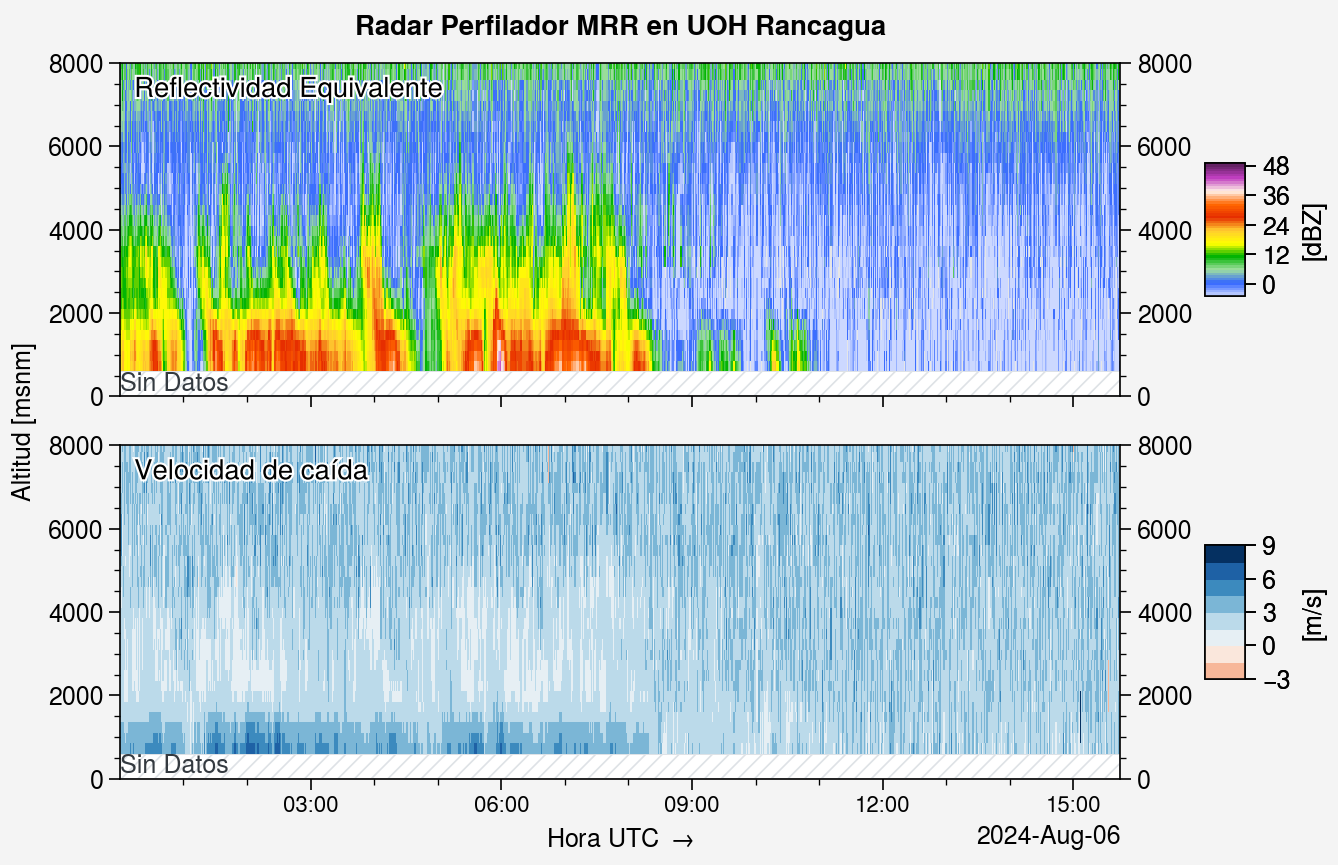

In [68]:
# Aplicar filtro adaptativo a los datos de reflectividad y velocidad de caída
Ze_filtrado = filtro_adaptativo_entorno(Ze, ventana_pequeña=5, ventana_grande=9, umbral_desviacion=5.0)
Vf_filtrado = filtro_adaptativo_entorno(Vf, ventana_pequeña=5, ventana_grande=9, umbral_desviacion=5.0)

# Llamar a la función plot_mrr2 con los datos filtrados
plot_mrr2(xlim, pd.to_datetime(ds.time.values), heights, Ze_filtrado, Vf_filtrado, hora_local=False)
plt.savefig("2024_0806_mrr2c_1_filtrado_adaptativo.png")

## Probamos KalmanFilter

In [69]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

# Iniciamos el filtro con la dimencionalidad requerida
f = KalmanFilter(dim_x=1, dim_z=1)

# Asignamos valores iniciales
f.x = np.array([[Ze[0, 0]]])  # reflectividad en el primer tiempo y primer nivel

# Definimos la matriz de transición de estado
f.F = np.array([[1]])

# Definimos la función de medición 
f.H = np.array([[1]])

# Covarianza del error de estado inicial por  la incertidumbre
f.P *= 1000  

# Ruido de medición (ajustar según el nivel de ruido que esperes)
f.R = 1                                         # PARAMETRO A MODIFICA

# Ruido del proceso 
f.Q = np.array([[0.5]])  # Ajusta el valor según el nivel de ruido esperado    PARAMETRO A MODIFICAR

In [70]:
# Crear una matriz para guardar los datos filtrados
Ze_filtered = np.zeros_like(Ze.values)  

# Aca aplicamos el filtro como por cada dato espacial existente
for i in range(Ze.shape[1]):  # para cada altura (1548 niveles de altura segun mis datos)
    
    f = KalmanFilter(dim_x=1, dim_z=1)
    f.x = np.array([[Ze.values[0, i]]])  
    f.F = np.array([[1]])  
    f.H = np.array([[1]])  
    f.P *= 1000  

    for k in range(Ze.shape[0]):  # para cada tiempo (31 tiempos)
        # Medición actual (reflectividad en el tiempo k y altura i)
        z = Ze.values[k, i]  # Usamos .values para convertir a numpy array
        
        f.predict()  # Predicción del siguiente estado
        f.update(z)  # Actualización con la medición actual
        
        # Guardar la reflectividad filtrada
        Ze_filtered[k, i] = f.x[0, 0]

# Ahora Ze_filtered contiene los datos filtrados por el filtro de Kalman


C:\Users\Kanty\anaconda3\envs\myenv\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\Kanty\anaconda3\envs\myenv\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\Kanty\AppData\Local\Temp\ipykernel_17764\1887986037.py:142: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


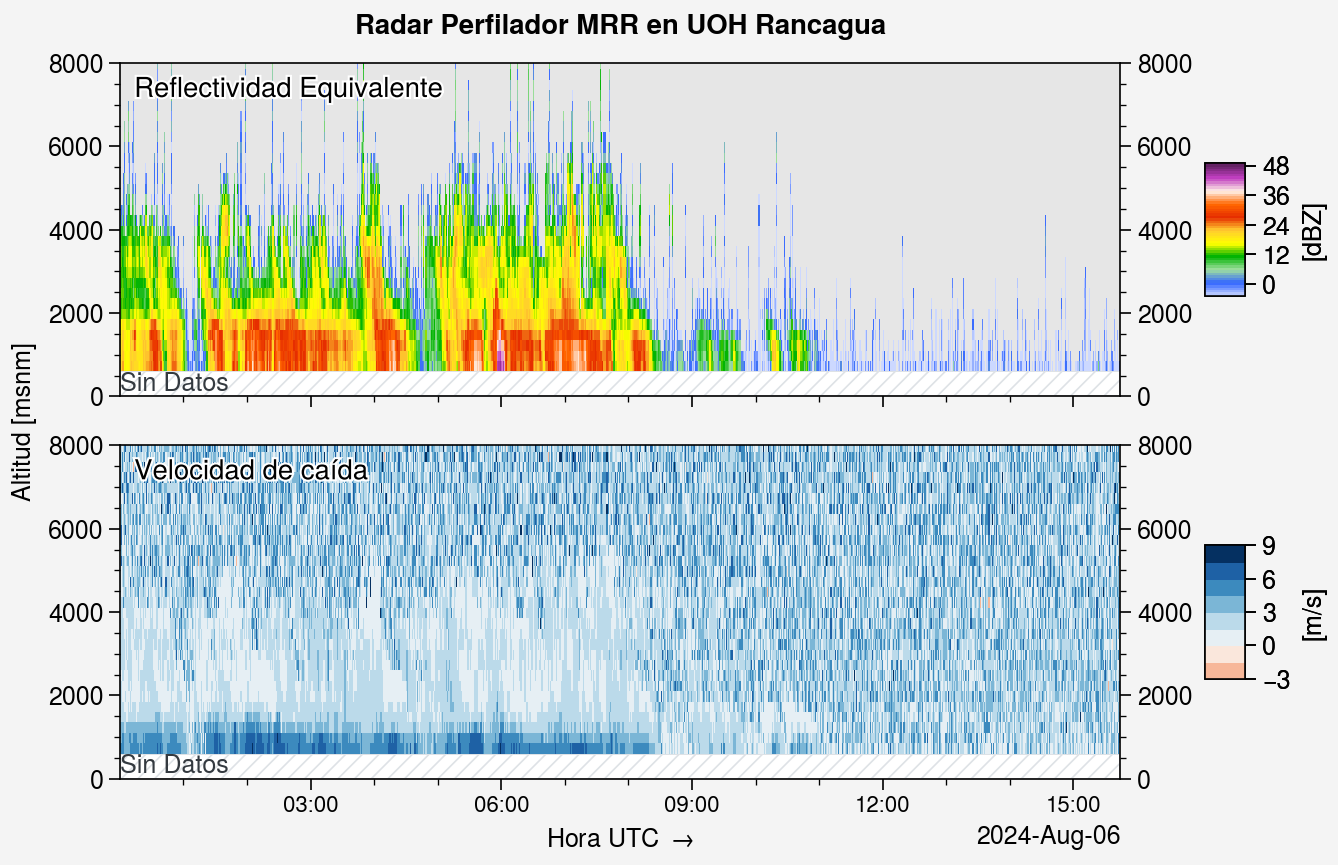

In [71]:
# Ploteamos los datos
plot_mrr2(xlim, pd.to_datetime(ds.time.values), heights, Ze_filtered, Vf, hora_local=False)

## KalmanFilter como funcion

In [56]:
def aplicar_filtro_kalman(Ze, R_ruido_medicion, Q_ruido_proceso):

    
    Ze_filtered = np.zeros_like(Ze.values)  
    for i in range(Ze.shape[1]):
        f = KalmanFilter(dim_x=1, dim_z=1)
        f.x = np.array([[Ze.values[0, i]]]) 
        f.F = np.array([[1]])  
        f.H = np.array([[1]])  
        f.P *= 1000  

        f.R = R_ruido_medicion  
        f.Q = np.array([[Q_ruido_proceso]])  

        for k in range(Ze.shape[0]):
            z = Ze.values[k, i]
            f.predict()
            f.update(z)
            Ze_filtered[k, i] = f.x[0, 0]

    return Ze_filtered



C:\Users\Kanty\anaconda3\envs\myenv\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\Kanty\anaconda3\envs\myenv\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\Kanty\AppData\Local\Temp\ipykernel_12432\1887986037.py:142: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


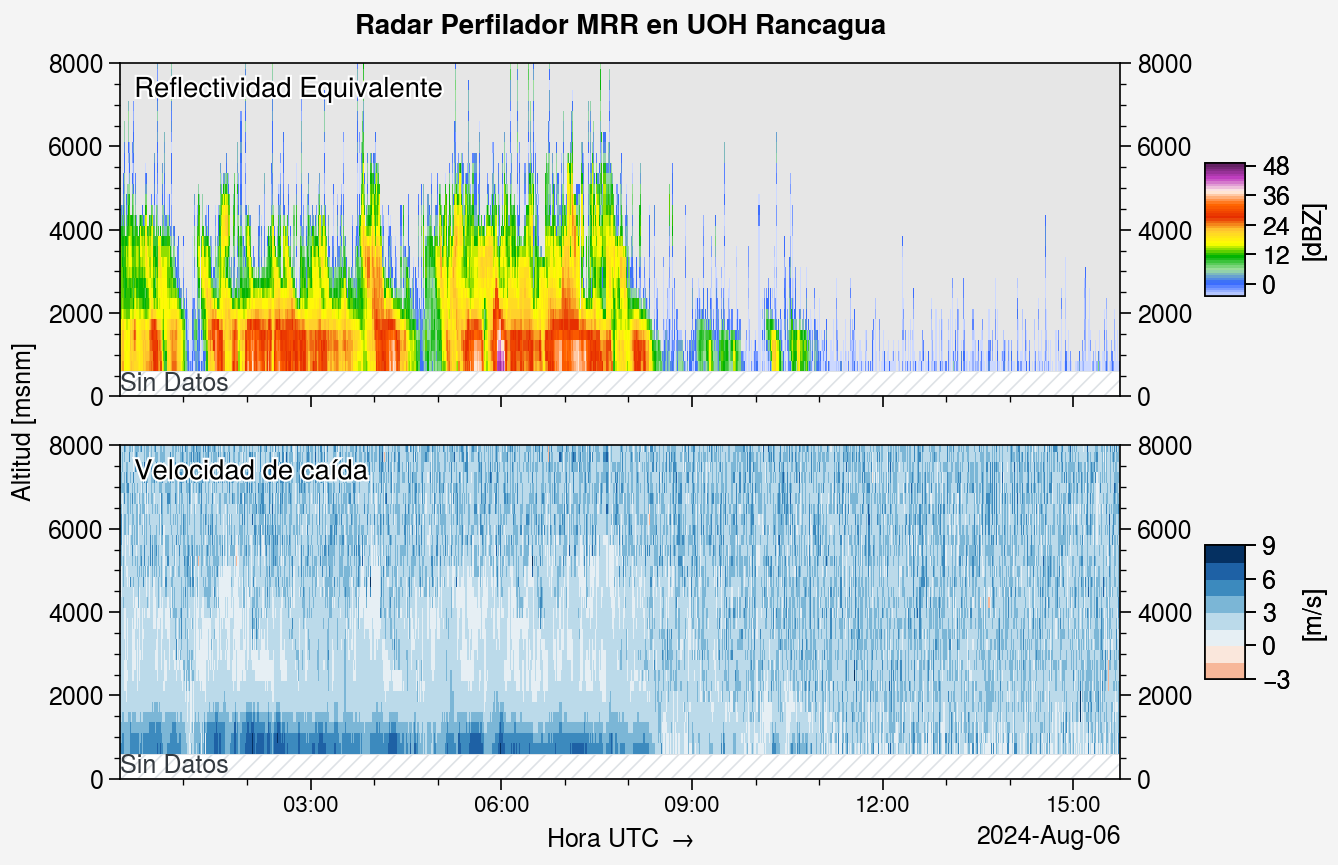

In [57]:
# Ploteamos los datos despues de usar el filtro
Ze_filtered = aplicar_filtro_kalman(Ze, 1 , 0.5)
Vf_filtered = aplicar_filtro_kalman(Vf, 1, 0.5)
plot_mrr2(xlim, pd.to_datetime(ds.time.values), heights, Ze_filtered, Vf_filtered, hora_local=False)



C:\Users\Kanty\anaconda3\envs\myenv\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\Kanty\anaconda3\envs\myenv\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\Kanty\AppData\Local\Temp\ipykernel_12432\1887986037.py:142: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


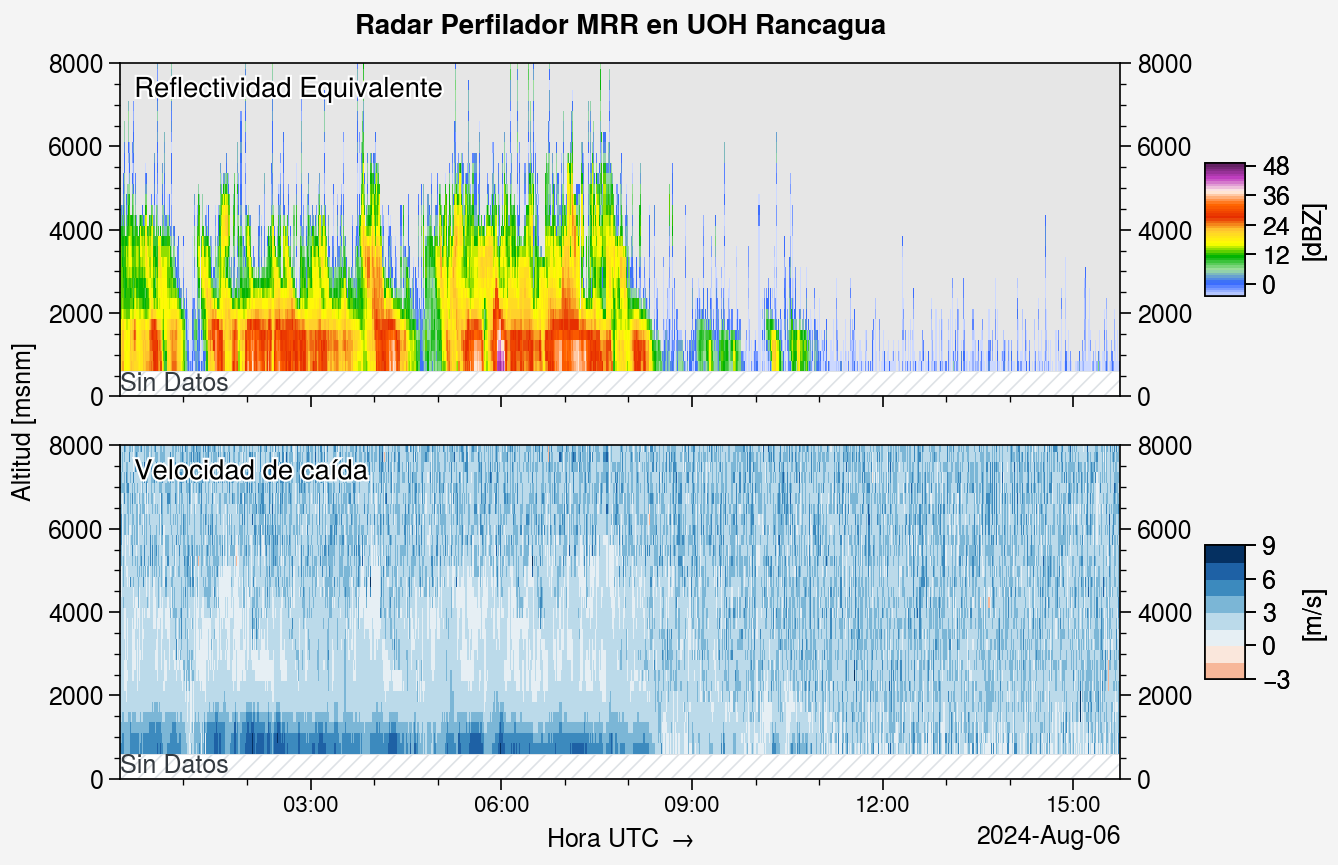

In [58]:
# Ploteamos los datos despues de usar el filtro
Ze_filtered = aplicar_filtro_kalman(Ze, 0.1 , 0.05)
Vf_filtered = aplicar_filtro_kalman(Vf, 0.1 , 0.05)
plot_mrr2(xlim, pd.to_datetime(ds.time.values), heights, Ze_filtered, Vf_filtered, hora_local=False)


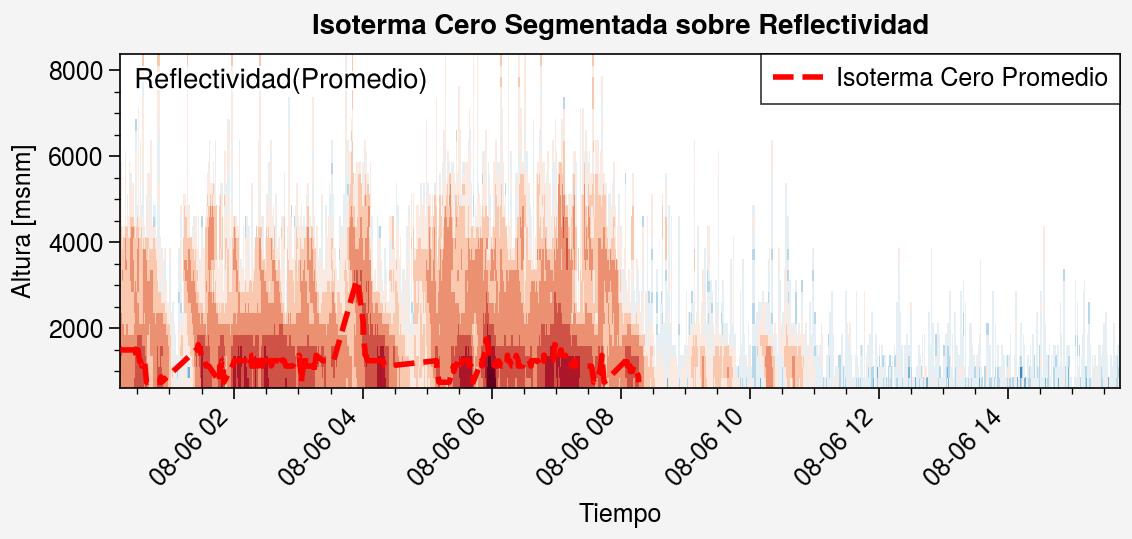

In [50]:
# Aplicar la función para encontrar máximos de reflectividad en los datos filtrados
tiempos_max, alturas_max = encontrar_maximos_reflectividad(Ze_filtered, heights)

# Graficar la isoterma cero utilizando los datos filtrados
plot_isoterma(xlim, pd.to_datetime(ds.time.values), heights, Ze_filtered, Vf, hora_local=False)


C:\Users\Kanty\AppData\Local\Temp\ipykernel_12432\1887986037.py:142: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


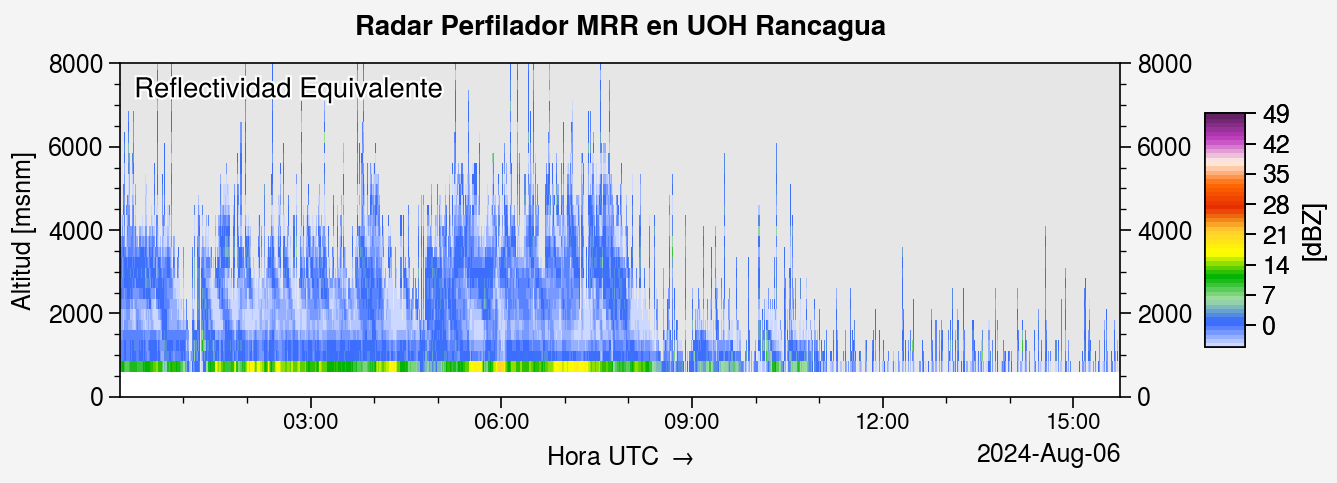

In [11]:
# Ajusta el tamaño del suavizado según tus necesidades
suavizado = 3
gradiente_Ze = calcular_gradiente(Ze_filtered, suavizado)

# Graficar el gradiente de reflectividad ya filtrado
plot_mrr2(xlim, pd.to_datetime(ds.time.values), heights, gradiente_Ze, hora_local=False)

ValueError: Input shapes x (1548,) and y (31,) must match array centers (31, 2414) or array borders (32, 2415).

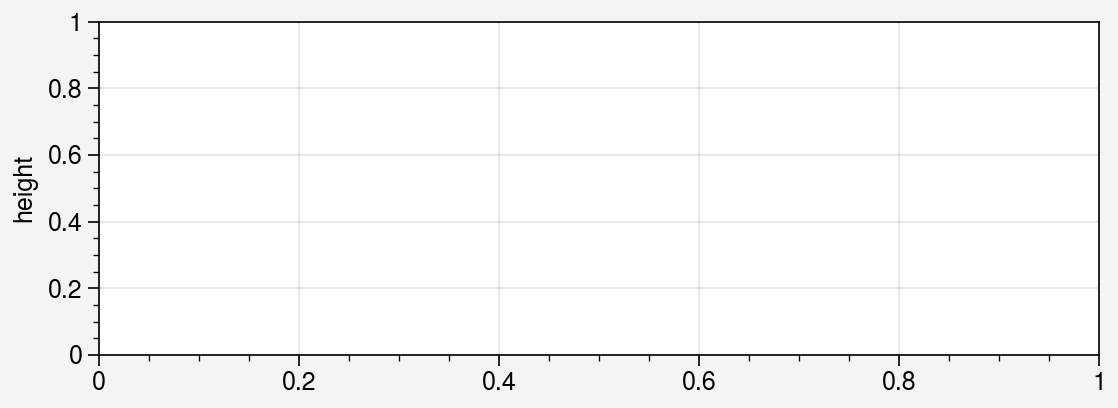

In [59]:
# Aplicar la función para encontrar máximos de reflectividad en los datos filtrados
tiempos_max, alturas_max = encontrar_maximos_reflectividad(Ze_filtered, heights)
# Aplicar la función isoterma segmentada sobre el gradiente de los datos filtrados
plot_isoterma(xlim, pd.to_datetime(ds.time.values), heights, gradiente_Ze, Vf=None, hora_local=False)

C:\Users\Kanty\AppData\Local\Temp\ipykernel_12432\1887986037.py:142: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


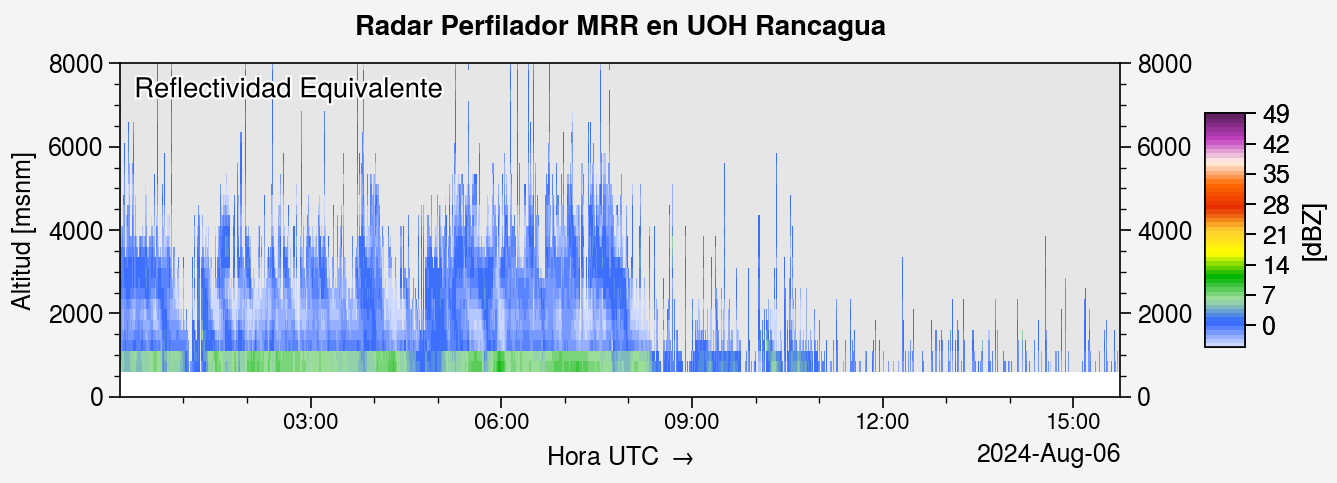

In [13]:
# Ajusta el tamaño del suavizado según tus necesidades
suavizado = 5
gradiente_Ze = calcular_gradiente(Ze_filtered, suavizado)

# Graficar el gradiente de reflectividad ya filtrado
plot_mrr2(xlim, pd.to_datetime(ds.time.values), heights, gradiente_Ze, hora_local=False)

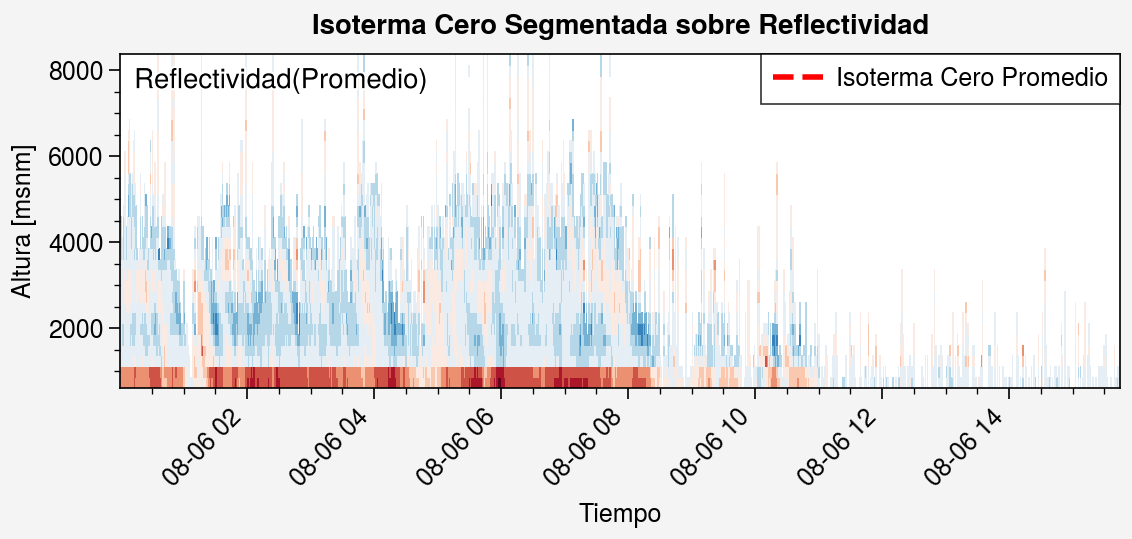

In [14]:
# Aplicar la función isoterma segmentada sobre el gradiente de los datos filtrados
plot_isoterma(xlim, pd.to_datetime(ds.time.values), heights, gradiente_Ze, Vf=None, hora_local=False)

C:\Users\Kanty\AppData\Local\Temp\ipykernel_12432\1887986037.py:142: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


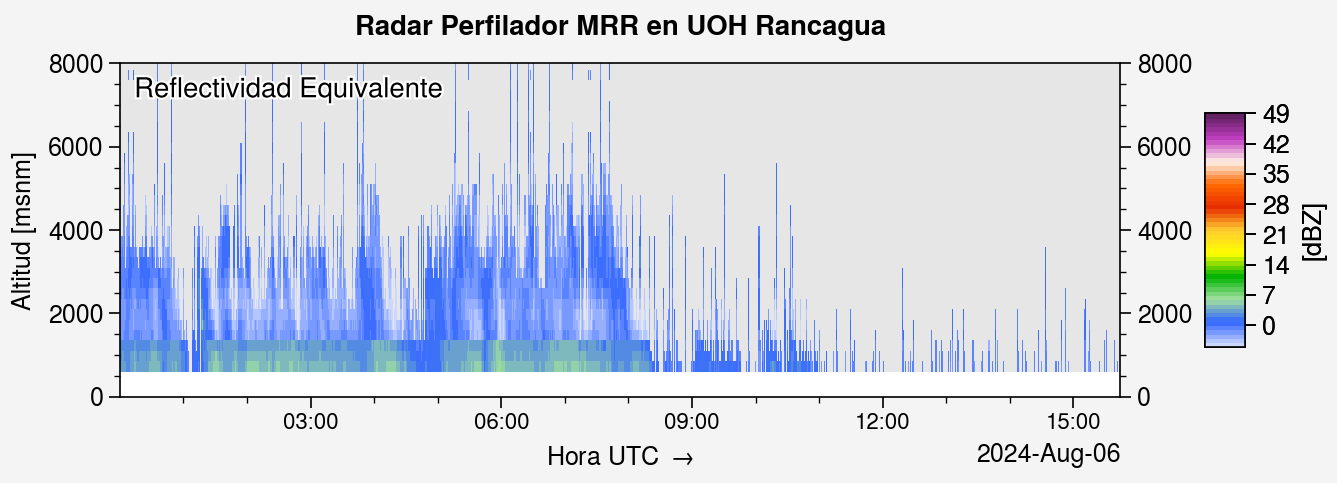

In [15]:
# Ajusta el tamaño del suavizado según tus necesidades
suavizado = 7
gradiente_Ze = calcular_gradiente(Ze_filtered, suavizado)

# Graficar el gradiente de reflectividad ya filtrado
plot_mrr2(xlim, pd.to_datetime(ds.time.values), heights, gradiente_Ze, hora_local=False)

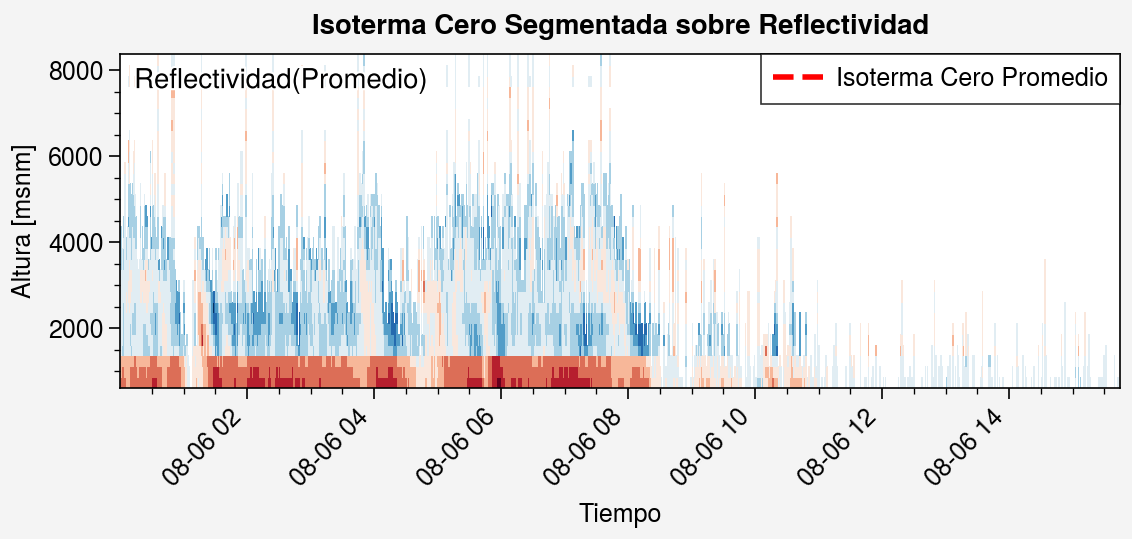

In [16]:
# Aplicar la función isoterma segmentada sobre el gradiente de los datos filtrados
plot_isoterma(xlim, pd.to_datetime(ds.time.values), heights, gradiente_Ze, Vf=None, hora_local=False)

C:\Users\Kanty\AppData\Local\Temp\ipykernel_12432\1887986037.py:142: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


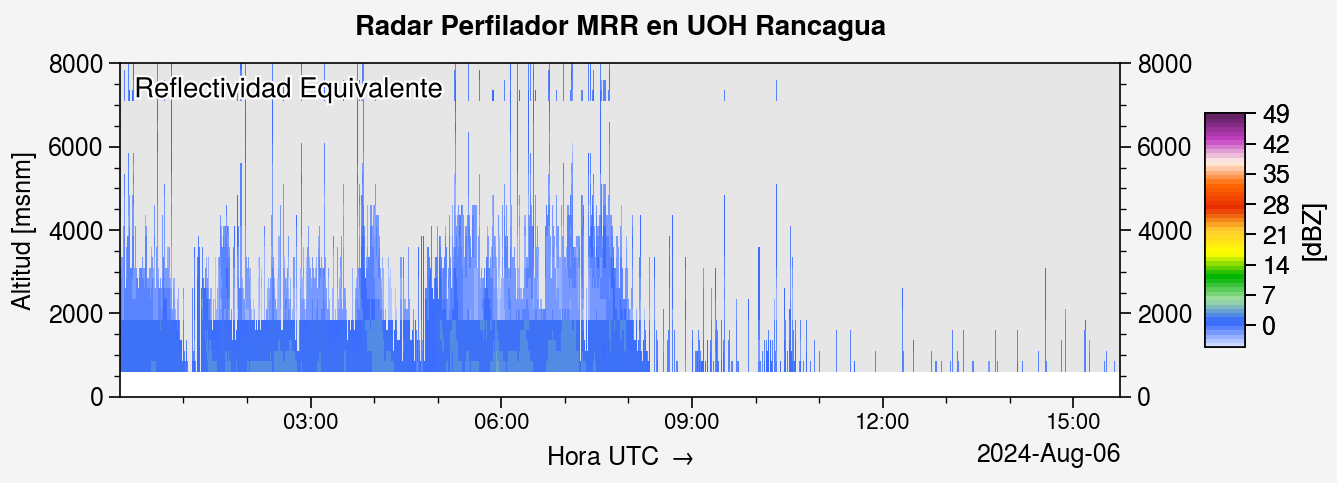

In [17]:
# Ajusta el tamaño del suavizado según tus necesidades
suavizado = 11
gradiente_Ze = calcular_gradiente(Ze_filtered, suavizado)

# Graficar el gradiente de reflectividad ya filtrado
plot_mrr2(xlim, pd.to_datetime(ds.time.values), heights, gradiente_Ze, hora_local=False)

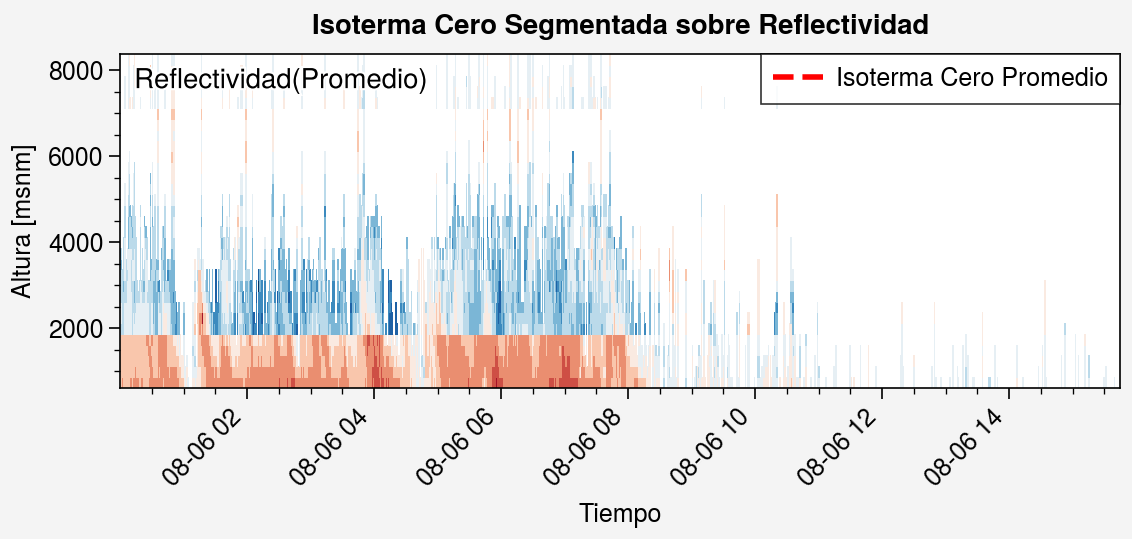

In [18]:
# Aplicar la función isoterma segmentada sobre el gradiente de los datos filtrados
plot_isoterma(xlim, pd.to_datetime(ds.time.values), heights, gradiente_Ze, Vf=None, hora_local=False)

In [33]:
#cargamos la base
ds1 = xr.open_dataset('C:/Users/Kanty/Documents/mrr2c/2024_0430_mrr2c_1.nc')
ds1.head()   # para ver la cantidad de variables y tipos

<xarray.Dataset>
Dimensions:                        (time: 5, level: 5, band: 5)
Coordinates:
  * band                           (band) float64 0.0 1.0 2.0 3.0 4.0
  * level                          (level) float64 0.0 1.0 2.0 3.0 4.0
  * time                           (time) datetime64[ns] 2024-04-30T00:00:46 ...
Data variables: (12/22)
    attenuated_radar_reflectivity  (time, level) float64 ...
    averaging_time                 (time) float64 ...
    calibration_constant           (time) float64 ...
    device_serial_number           (time) object ...
    drop_size                      (time, level, band) float64 ...
    fall_velocity                  (time, level) float64 ...
    ...                             ...
    service_version                (time) object ...
    spectral_drop_density          (time, level, band) float64 ...
    spectral_reflectivity          (time, level, band) float64 ...
    time_zone                      (time) object ...
    transfer_function              (time, level) float64 ...
    valid_spectra_percentage       (time) float64 ...
Attributes:
    software:  mrr2c (https://github.com/peterkuma/mrr2c)
    version:   3.0.0
    created:   2024-05-09T12:13:09Z

C:\Users\Kanty\anaconda3\envs\myenv\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\Kanty\anaconda3\envs\myenv\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\Kanty\AppData\Local\Temp\ipykernel_12432\1887986037.py:142: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


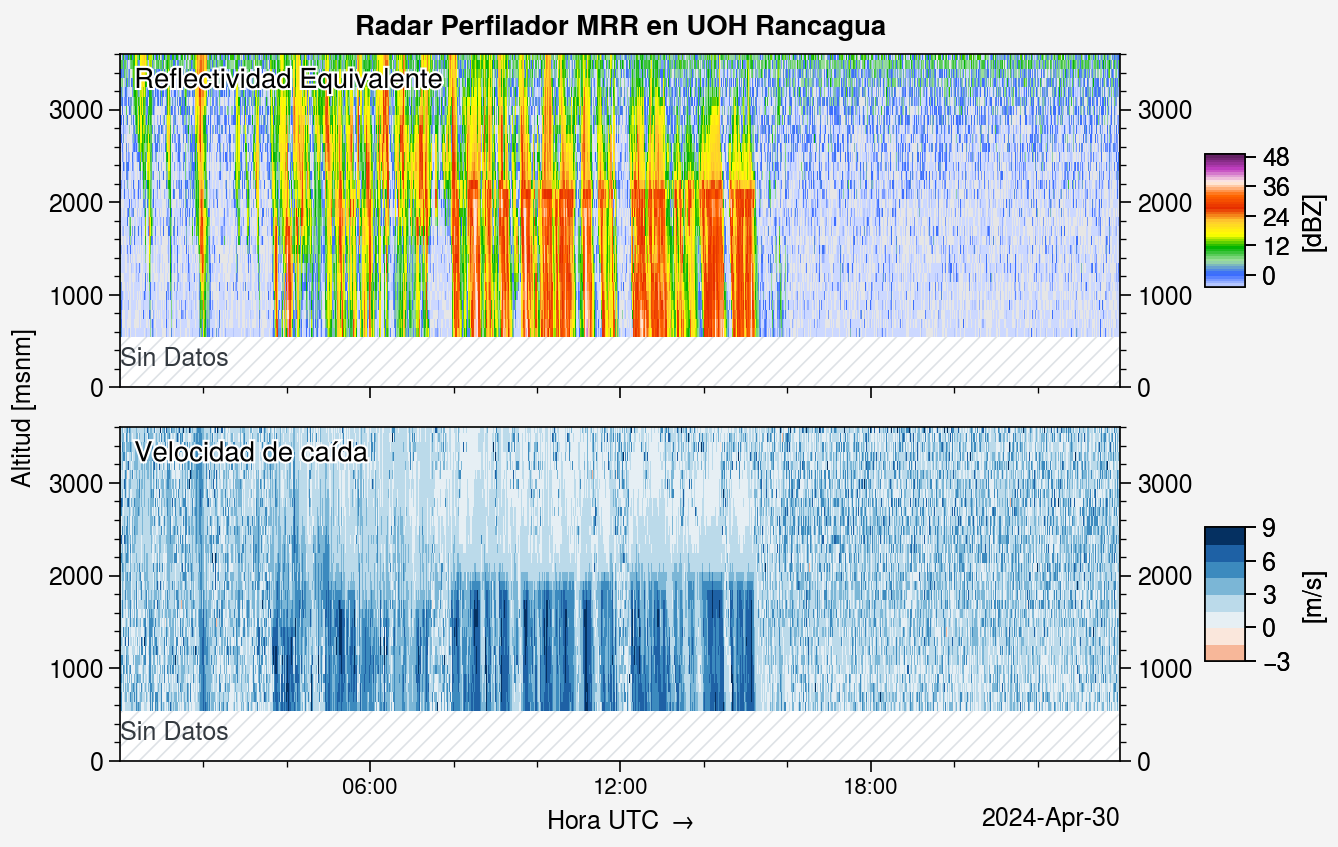

In [34]:
new_time = pd.to_datetime(ds1.time.values)
xlim = [new_time[0], new_time[-1]]
heights = ds1.height[0,:]+500
Ze = ds1['attenuated_radar_reflectivity'].T
Vf = ds1['fall_velocity'].T
# llamar a la funcion para plotear
plot_mrr2(xlim,pd.to_datetime(ds1.time.values) , heights, Ze, Vf, hora_local=False)
plt.savefig("2024_0523_mrr2c_2.png")

C:\Users\Kanty\anaconda3\envs\myenv\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\Kanty\anaconda3\envs\myenv\lib\site-packages\proplot\axes\plot.py:1275: UserWarning: No contour levels were found within the data range.
  obj = getattr(super(), name)(*args, **kwargs)
C:\Users\Kanty\AppData\Local\Temp\ipykernel_12432\1887986037.py:142: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


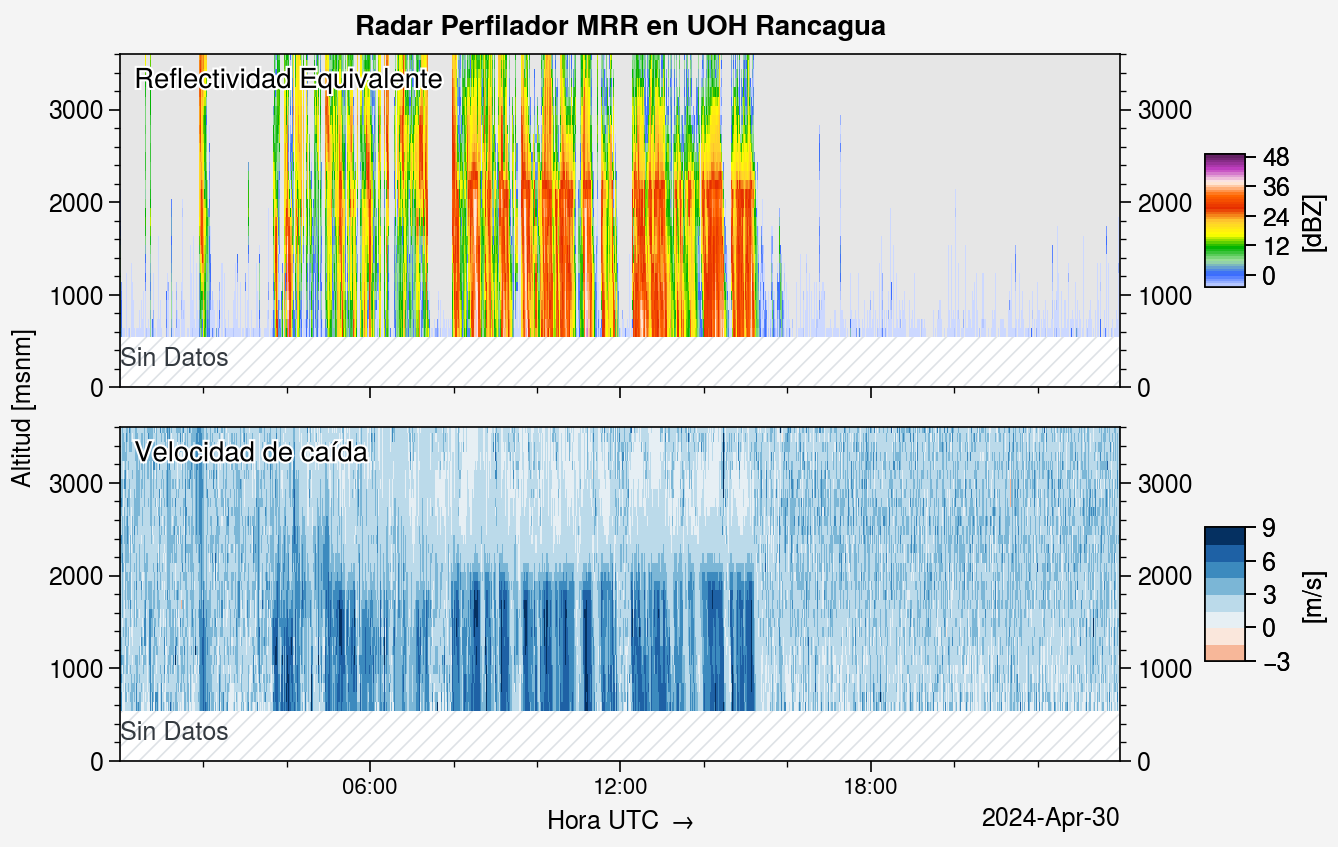

In [35]:
# Ploteamos los datos despues de usar el filtro
Ze_filtered = aplicar_filtro_kalman(Ze, 1 , 0.5)
Vf_filtered = aplicar_filtro_kalman(Vf, 1, 0.5)
plot_mrr2(xlim, pd.to_datetime(ds1.time.values), heights, Ze_filtered, Vf_filtered, hora_local=False)

C:\Users\Kanty\AppData\Local\Temp\ipykernel_12432\1887986037.py:142: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


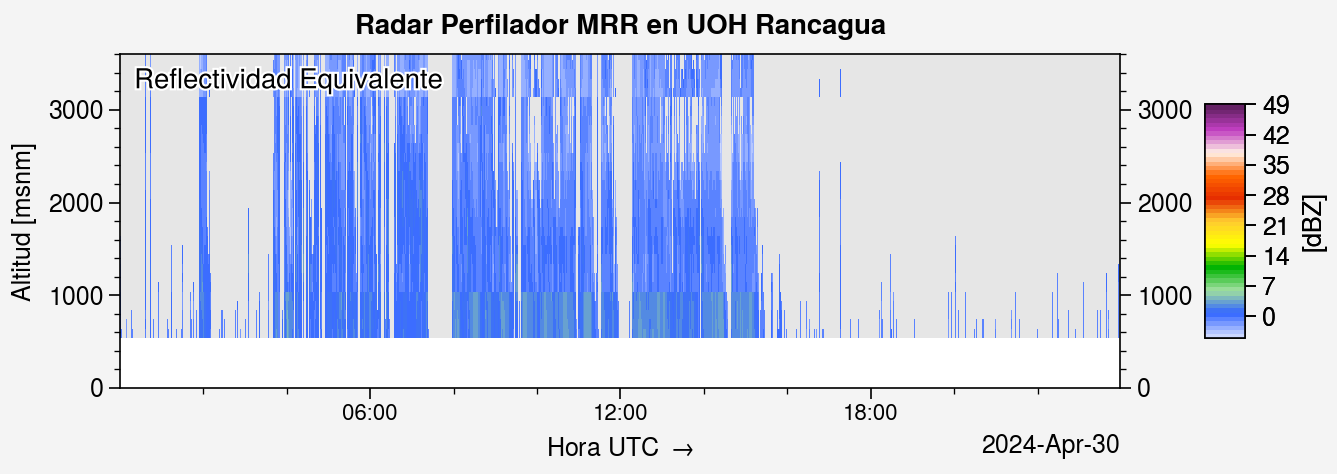

In [42]:
# Ajusta el tamaño del suavizado según tus necesidades
suavizado = 11
gradiente_Ze = calcular_gradiente(Ze_filtered, suavizado)

# Graficar el gradiente de reflectividad ya filtrado
plot_mrr2(xlim, pd.to_datetime(ds1.time.values), heights, gradiente_Ze, hora_local=False)

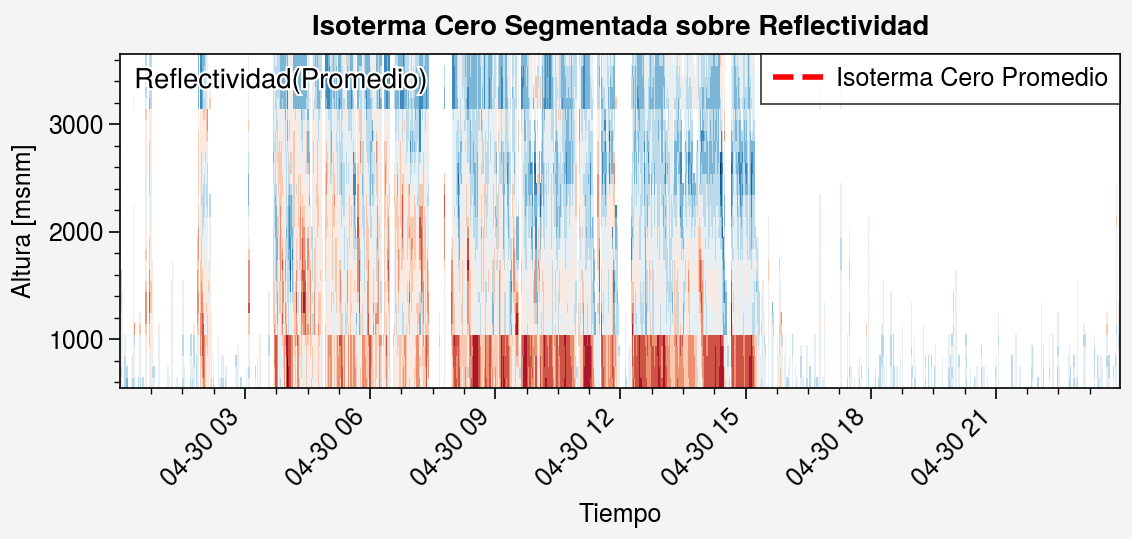

In [43]:
# Aplicar la función isoterma segmentada sobre el gradiente de los datos filtrados
plot_isoterma(xlim, pd.to_datetime(ds1.time.values), heights, gradiente_Ze, Vf=None, hora_local=False)